# Load Dataset from Kaggle

In [ ]:
import kagglehub

In [ ]:
path = kagglehub.dataset_download("vuppalaadithyasairam/ultrasound-breast-images-for-breast-cancer")

print("Path to dataset files:", path)

100%|██████████| 564M/564M [00:09<00:00, 65.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vuppalaadithyasairam/ultrasound-breast-images-for-breast-cancer/versions/1


# Check Content

In [ ]:
import os

In [ ]:
def list_directories(base_path):
    for root, dirs, files in os.walk(base_path):
        for d in dirs:
            full_path = os.path.join(root, d)
            relative_path = os.path.relpath(full_path, base_path)
            print(relative_path)

dataset_path = os.path.join(path, "ultrasound breast classification")

list_directories(dataset_path)

train
val
train/malignant
train/benign
val/malignant
val/benign


# Image Count per Class

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
image_counts = {}

for split in ['train', 'val']:
    split_path = os.path.join(dataset_path, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            count = len(os.listdir(label_path))
            image_counts[f"{split}/{label}"] = count

print(image_counts)

{'train/malignant': 4042, 'train/benign': 4074, 'val/malignant': 400, 'val/benign': 500}


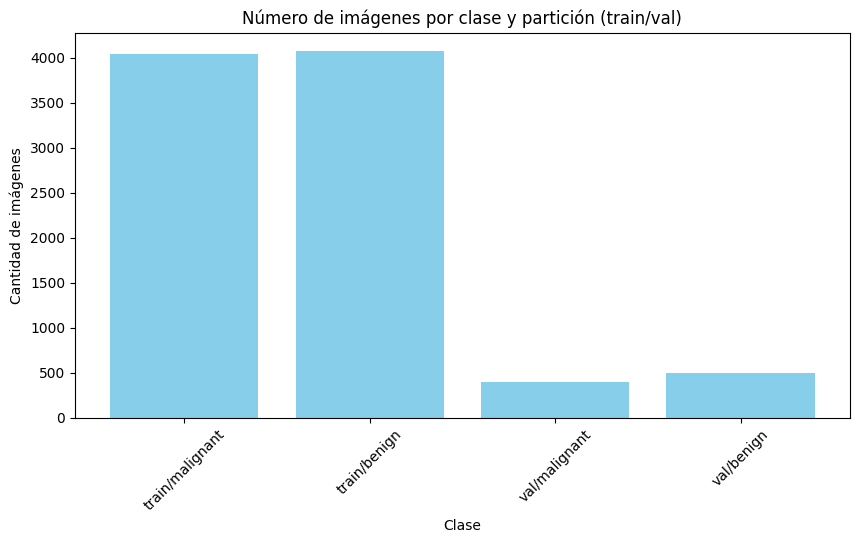

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.title("Número de imágenes por clase y partición (train/val)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45)
plt.show()

# Images

In [ ]:
from PIL import Image
import numpy as np

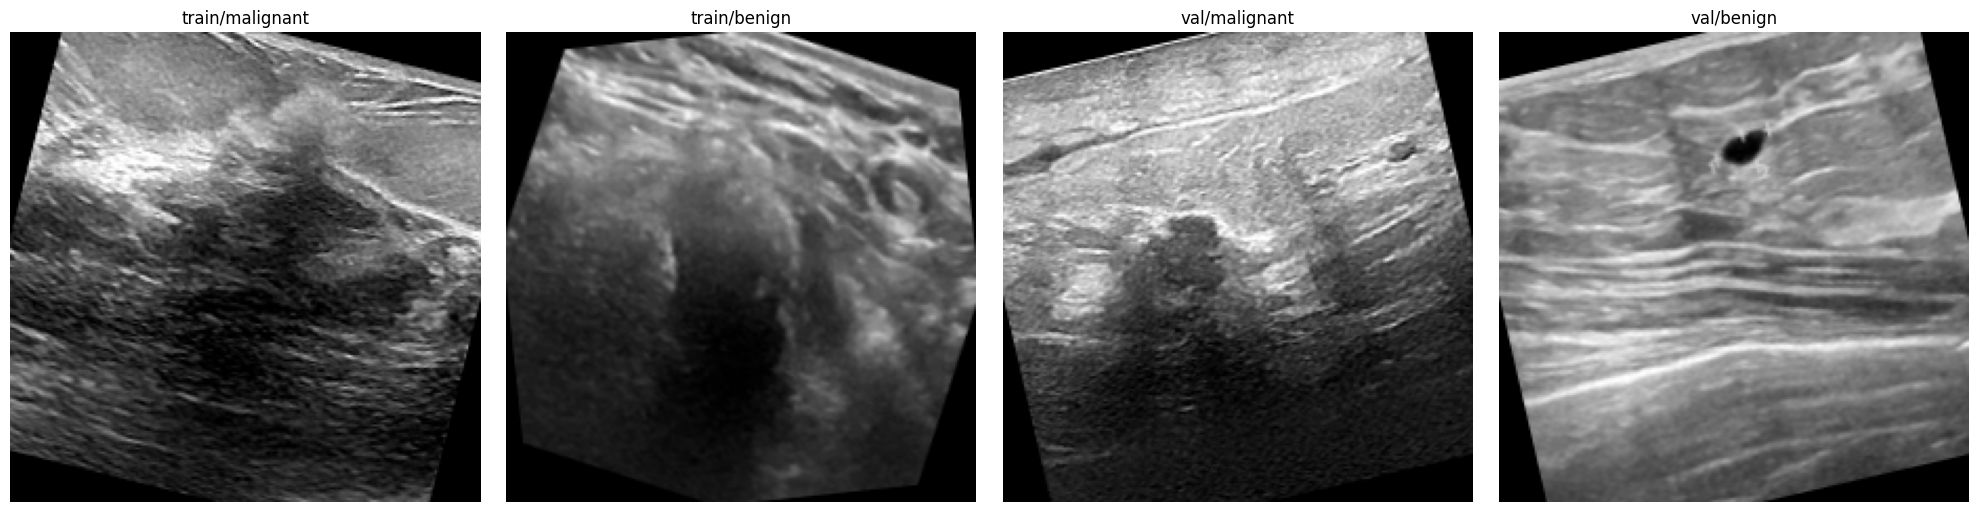

In [ ]:
fig, axes = plt.subplots(1, len(image_counts), figsize=(20, 5))

for i, label in enumerate(image_counts.keys()):
    image_folder = os.path.join(dataset_path, label)
    image_files = os.listdir(image_folder)

    if len(image_files) > 0:
        image_path = os.path.join(image_folder, image_files[0])
        img = Image.open(image_path)
        axes[i].imshow(img.convert("L"), cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    else:
        axes[i].set_title(f"{label}\n(sin imágenes)")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Average Dimensions

In [ ]:
dims = []

for label in image_counts.keys():
    folder = os.path.join(dataset_path, label)
    for img_name in os.listdir(folder)[:50]:
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        dims.append(img.size)

dims = np.array(dims)
print(f"Dimensiones promedio (width, height): {np.mean(dims, axis=0)}")

Dimensiones promedio (width, height): [224.21 224.21]


# Data Segmentation

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 8116 files belonging to 2 classes.
Found 900 files belonging to 2 classes.


# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds_augmented = train_ds_augmented.prefetch(buffer_size=AUTOTUNE)

# Models

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [ ]:
MobileNetV2_base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
MobileNetV2_base_model.trainable = False

MobileNetV2_model = models.Sequential([
    MobileNetV2_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

MobileNetV2_model_aug = models.Sequential([
    MobileNetV2_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
MobileNetV2_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

MobileNetV2_model_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [ ]:
MobileNetV2_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.7869 - loss: 0.4570 - val_accuracy: 0.8700 - val_loss: 0.2957
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.8985 - loss: 0.2371 - val_accuracy: 0.8656 - val_loss: 0.3142
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9167 - loss: 0.1943 - val_accuracy: 0.8722 - val_loss: 0.2972
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9401 - loss: 0.1453 - val_accuracy: 0.8733 - val_loss: 0.2988
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9405 - loss: 0.1384 - val_accuracy: 0.9078 - val_loss: 0.2444
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9522 - loss: 0.1239 - val_accuracy: 0.8967 - val_loss: 0.2804
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9547 - loss: 0.1168 - val_accuracy: 0.8733 - val_loss: 0.3237
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9584 - loss: 0.1041 -

In [ ]:
MobileNetV2_model_aug.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 117s 426ms/step - accuracy: 0.7373 - loss: 0.6021 - val_accuracy: 0.8333 - val_loss: 0.3483
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 103s 405ms/step - accuracy: 0.8304 - loss: 0.3677 - val_accuracy: 0.8589 - val_loss: 0.3198
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 111s 434ms/step - accuracy: 0.8467 - loss: 0.3362 - val_accuracy: 0.8711 - val_loss: 0.3127
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 105s 410ms/step - accuracy: 0.8592 - loss: 0.3134 - val_accuracy: 0.8867 - val_loss: 0.2743
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 105s 410ms/step - accuracy: 0.8728 - loss: 0.2861 - val_accuracy: 0.8689 - val_loss: 0.2806
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 140s 405ms/step - accuracy: 0.8741 - loss: 0.2859 - val_accuracy: 0.8756 - val_loss: 0.2975
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 102s 401ms/step - accuracy: 0.8830 - loss: 0.2677 - val_accuracy: 0.8733 - val_loss: 0.2797
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 103s 404ms/step - accuracy: 0.8823 -

# Models Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step


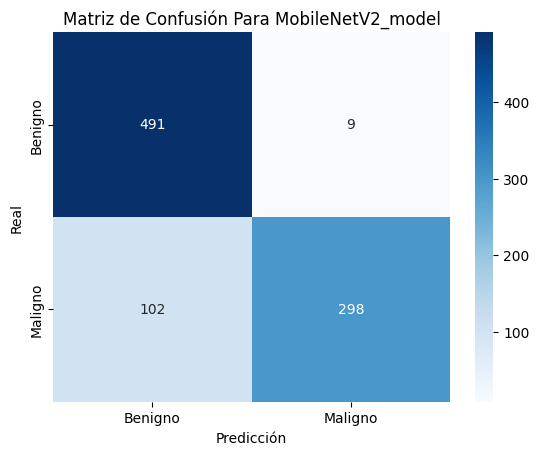

              precision    recall  f1-score   support

     Benigno       0.83      0.98      0.90       500
     Maligno       0.97      0.74      0.84       400

    accuracy                           0.88       900
   macro avg       0.90      0.86      0.87       900
weighted avg       0.89      0.88      0.87       900



In [ ]:
y_pred_probs = MobileNetV2_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Para MobileNetV2_model')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step


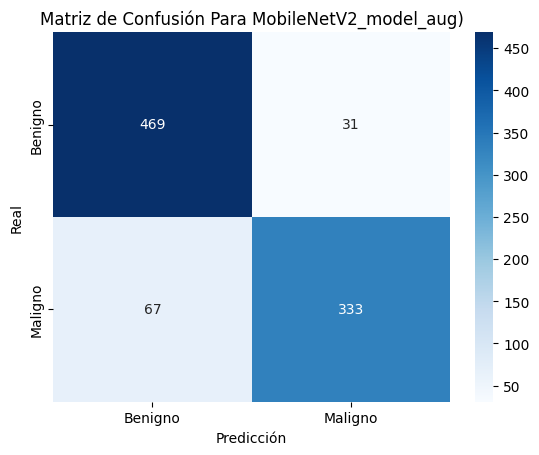

              precision    recall  f1-score   support

     Benigno       0.88      0.94      0.91       500
     Maligno       0.91      0.83      0.87       400

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



In [ ]:
y_pred_probs_aug = MobileNetV2_model_aug.predict(val_ds)
y_pred_aug = np.argmax(y_pred_probs_aug, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred_aug)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Para MobileNetV2_model_aug)')
plt.show()

print(classification_report(y_true, y_pred_aug, target_names=['Benigno', 'Maligno']))

# Fine-tuning

In [ ]:
MobileNetV2_base_model.trainable = True
for layer in MobileNetV2_base_model.layers[:-4]:
    layer.trainable = False

In [26]:
MobileNetV2_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

MobileNetV2_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.9585 - loss: 0.1212 - val_accuracy: 0.8822 - val_loss: 0.3500
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9611 - loss: 0.0951 - val_accuracy: 0.9056 - val_loss: 0.2740
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9706 - loss: 0.0769 - val_accuracy: 0.9056 - val_loss: 0.2617
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9761 - loss: 0.0641 - val_accuracy: 0.9156 - val_loss: 0.2334
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9764 - loss: 0.0649 - val_accuracy: 0.9233 - val_loss: 0.2366


In [27]:
MobileNetV2_model_aug.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

MobileNetV2_model_aug.fit(train_ds_augmented, validation_data=val_ds, epochs=5)

Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 130s 465ms/step - accuracy: 0.8686 - loss: 0.3198 - val_accuracy: 0.8811 - val_loss: 0.2654
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 121s 403ms/step - accuracy: 0.8931 - loss: 0.2569 - val_accuracy: 0.8867 - val_loss: 0.2486
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 104s 408ms/step - accuracy: 0.9002 - loss: 0.2239 - val_accuracy: 0.8933 - val_loss: 0.2412
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 105s 410ms/step - accuracy: 0.9017 - loss: 0.2246 - val_accuracy: 0.8967 - val_loss: 0.2334
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 102s 402ms/step - accuracy: 0.9094 - loss: 0.2178 - val_accuracy: 0.8956 - val_loss: 0.2320


# Fine-tuning Evaluation

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step


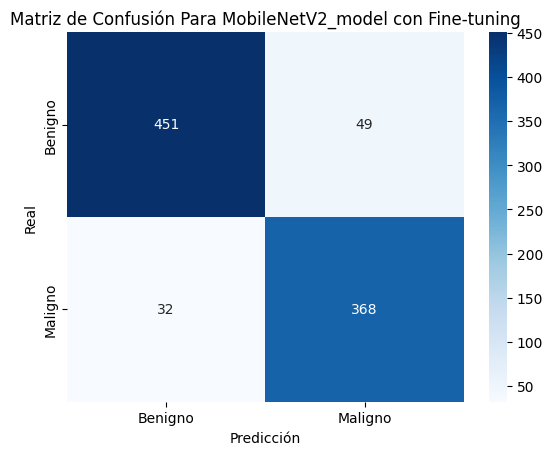

              precision    recall  f1-score   support

     Benigno       0.93      0.90      0.92       500
     Maligno       0.88      0.92      0.90       400

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



In [28]:
y_pred_probs = MobileNetV2_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Para MobileNetV2_model con Fine-tuning')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step


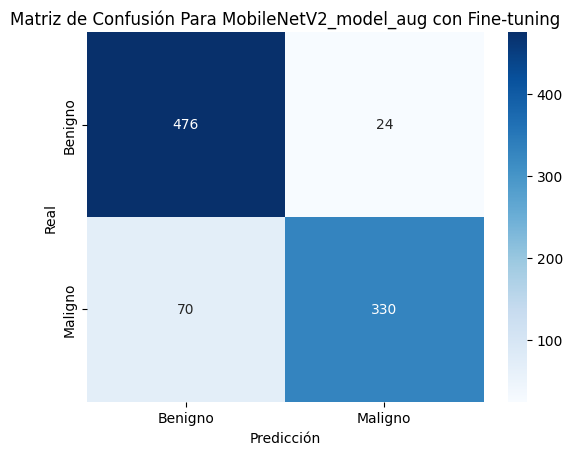

              precision    recall  f1-score   support

     Benigno       0.87      0.95      0.91       500
     Maligno       0.93      0.82      0.88       400

    accuracy                           0.90       900
   macro avg       0.90      0.89      0.89       900
weighted avg       0.90      0.90      0.89       900



In [29]:
y_pred_probs_aug = MobileNetV2_model_aug.predict(val_ds)
y_pred_aug = np.argmax(y_pred_probs_aug, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred_aug)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Para MobileNetV2_model_aug con Fine-tuning')
plt.show()

print(classification_report(y_true, y_pred_aug, target_names=['Benigno', 'Maligno']))